### Import librabries

In [126]:
! pip install tqdm
! pip install keras
! pip install tensorflow
!pip install cv2

ERROR: Could not find a version that satisfies the requirement cv2
ERROR: No matching distribution found for cv2


In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import csv

import os
from tqdm.notebook import tqdm

from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import keras
from keras.layers import Dense, Conv2D, Activation,BatchNormalization, MaxPooling2D, Dropout, Flatten
from keras.models import load_model, Sequential
from keras.layers.advanced_activations import LeakyReLU



### 1. Read the dataset

#### 1.2 Read labels

In [128]:
# read labels
df_labels = pd.read_csv(r'C:\users\asus\Desktop\dataset\label.csv')

In [129]:
df_labels.head(10)

,file_name,label
0,IMAGE_0000.jpg,meningioma_tumor
1,IMAGE_0001.jpg,no_tumor
2,IMAGE_0002.jpg,meningioma_tumor
3,IMAGE_0003.jpg,glioma_tumor
4,IMAGE_0004.jpg,meningioma_tumor
5,IMAGE_0005.jpg,meningioma_tumor
6,IMAGE_0006.jpg,no_tumor
7,IMAGE_0007.jpg,glioma_tumor
8,IMAGE_0008.jpg,glioma_tumor
9,IMAGE_0009.jpg,pituitary_tumor


In [99]:
df_labels.count()

file_name    3000
label        3000
dtype: int64

In [130]:
df_labels['tumor'] = 1
df_labels['tumor'][df_labels['label'] == 'no_tumor'] = 0

<ipython-input-130-abd207aa7833>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_labels['tumor'][df_labels['label'] == 'no_tumor'] = 0


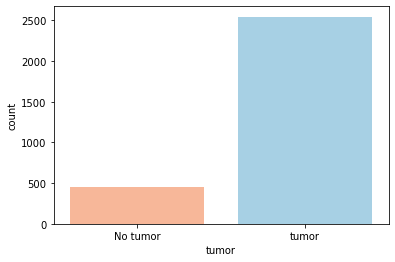

In [131]:
plt.figure()
sns.countplot(x='tumor',  data=df_labels, palette='RdBu', saturation=1)
plt.xticks([0,1], ['No tumor', 'tumor'])
plt.show()

In [102]:
df_labels['tumor_type'] = df_labels['tumor']
df_labels['tumor_type'] = df_labels['label'].map({'no_tumor': 0, 'meningioma_tumor': 1, 'glioma_tumor': 2, 'pituitary_tumor': 3 })

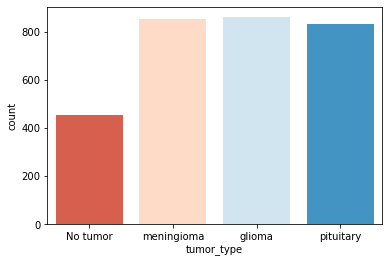

In [103]:
plt.figure()
sns.countplot(x='tumor_type',  data=df_labels, palette='RdBu', saturation=1)
plt.xticks([0,1,2,3], ['No tumor', 'meningioma','glioma', 'pituitary'])
plt.show()

In [104]:
df_labels.to_csv('p_labels.csv')

#### 2.2 Read images

In [132]:
Img_id = df_labels['file_name']

In [136]:
imgs =[np.array(image.load_img(r"\users\asus\Desktop\dataset\image\{}".format(i),target_size=(100,100), color_mode = "grayscale"))/255 for i in tqdm(Img_id[:Img_id.size])]

  0%|          | 0/3000 [00:00<?, ?it/s]

In [137]:
imgs_arr = np.array(imgs)

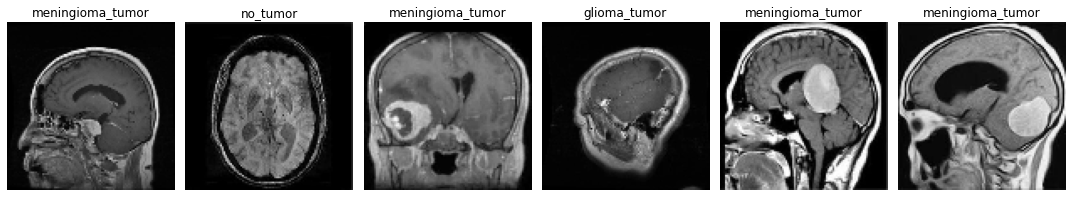

In [138]:
# show samples
plt.figure(figsize=(15, 10))
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(imgs_arr[i],cmap='gray')
    plt.title(df_labels.label[i])
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [139]:
imgs_arr = imgs_arr.reshape(imgs_arr.shape[0], imgs_arr.shape[1], imgs_arr.shape[2], 1)

In [140]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(imgs_arr, df_labels.tumor, test_size=0.2, random_state=42, stratify=df_labels.tumor)

In [141]:
X_train_reshaped = X_train.reshape((X_train.shape[0], X_train.shape[1]*X_train.shape[2]*X_train.shape[3]))
X_test_reshaped = X_test.reshape((X_test.shape[0], X_test.shape[1]*X_test.shape[2]*X_test.shape[3]))

### 2. Baseline models

#### 2.1 KNN

In [142]:
from sklearn.neighbors import KNeighborsClassifier

# Create a k-NN classifier with 7 neighbors: knn
knn = KNeighborsClassifier(n_neighbors=7)

# Fit the classifier to the training data
knn.fit(X_train_reshaped, y_train)

# Print the accuracy
print(knn.score(X_train_reshaped, y_train))

# Print the accuracy
print(knn.score(X_test_reshaped, y_test))

0.9225
0.895


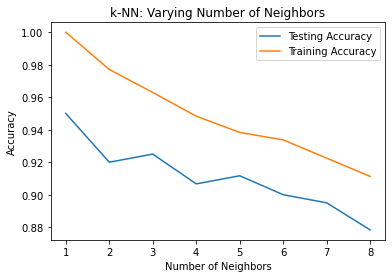

In [143]:
# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors = k)

    # Fit the classifier to the training data
    knn.fit(X_train_reshaped, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train_reshaped, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test_reshaped, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

####2.2 SVM

In [144]:
# SVM

# Import necessary modules
from sklearn.svm import SVC

# Instantiate the SVC classifier: clf
clf = SVC()

# Fit the pipeline to the train set
clf.fit(X_train_reshaped, y_train)

SVC()

In [145]:
# Predict the labels of the test set
y_pred = clf.predict(X_test_reshaped)

# Compute metrics
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.57      0.69        91
           1       0.93      0.98      0.96       509

    accuracy                           0.92       600
   macro avg       0.90      0.78      0.82       600
weighted avg       0.92      0.92      0.91       600



In [146]:
print(confusion_matrix(y_test, y_pred))

[[ 52  39]
 [  8 501]]


In [147]:
imgs_arr.shape

(3000, 100, 100, 1)

In [148]:
X_train[0].shape

(100, 100, 1)

#### 2.3 CNN

### 3. Main model

#### 3.2 Handling data imbalance (data augmentation)